# Lecture 4: Performance analysis


![](https://www.tensorflow.org/images/colab_logo_32px.png)
[Run in colab](https://colab.research.google.com/drive/1qRS7NIEctu9MaqafI5IpK9RWG3yyMYO1)

In [1]:
import datetime
now = datetime.datetime.now()
print("Last executed: " + now.strftime("%Y-%m-%d %H:%M:%S"))

Last executed: 2023-01-18 22:44:21


## Examining datasets

Use the MNIST digit dataset as a worked example in this lecture.

### Fetch MNIST data

In [2]:
# Common imports
import os
import numpy as np
np.random.seed(42) # To make this notebook's output stable across runs

In [3]:
# Fetch MNIST dataset
from sklearn.datasets import fetch_openml
#mnist = fetch_openml('mnist_784')
mnist = fetch_openml('mnist_784', parser="pandas")

### Extract features and targets

MNIST dataset is already split into standard training set (first 60,000 images) and test set (last 10,000 images).

In [4]:
# targets
y_train = mnist.target[:60000].to_numpy(dtype=int)
y_test = mnist.target[-10000:].to_numpy(dtype=int)
y_train.shape, y_test.shape

((60000,), (10000,))

In [5]:
# features
X_train = mnist.data[:60000].to_numpy()
X_test = mnist.data[-10000:].to_numpy()
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

Each datum corresponds to a 28 x 28 image.

In [6]:
import math
n_float = np.sqrt(X_train.shape[1])
n = math.floor(n_float)
print(n_float, n)

28.0 28


### Plot image of digit

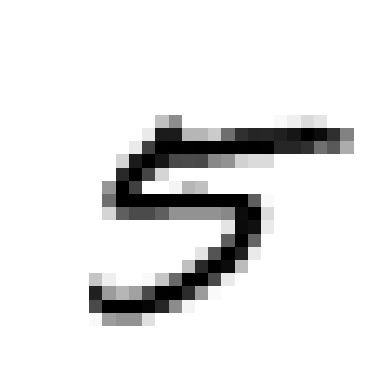

In [7]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

some_digit = X_train[41000]
some_digit_image = some_digit.reshape(n, n)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary,
           interpolation="nearest")
plt.axis("off");

**Exercises:** *You can now complete Exercise 1 in the exercises associated with this lecture.*

### Plot selection of digits

In [8]:
# Extract digits
n_digits = 10
n_images = 10
example_images = np.zeros([n_images * n_digits, n*n])
for i in range(n_digits):
    example_images[i*n_images:(i+1)*n_images,:] =  X_train[np.where(y_train == i)][0:n_images,:]

<Figure size 1000x1000 with 0 Axes>

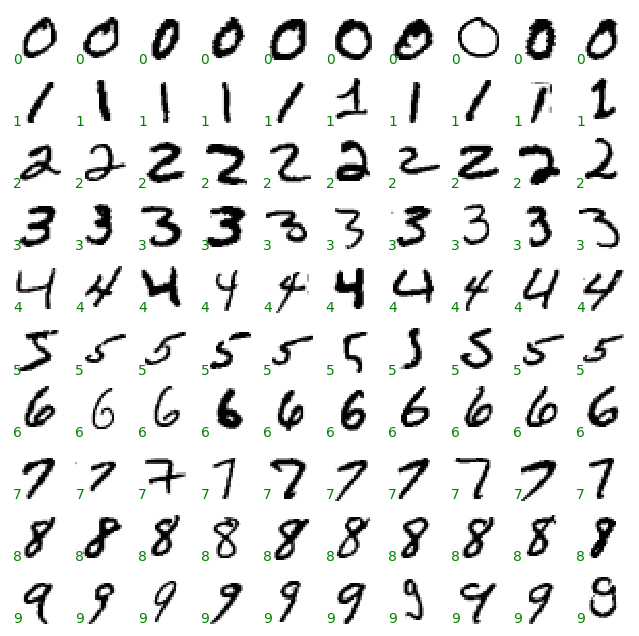

In [9]:
# Plot digits
plt.figure(figsize=(10,10))
fig, axes = plt.subplots(n_digits, n_images, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(example_images[i].reshape(n,n), cmap='binary', interpolation='nearest')
    ax.axis("off")
    ax.text(0.05, 0.05, str(i // n_images),
            transform=ax.transAxes, color='green')

In [10]:
def plot_digit(data):
    image = data.reshape(n, n)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off");

Shuffle training data so not ordered by type.

In [11]:
# Shuffle training data
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary classifier

Construct a classify to distinguish between 5s and all other digits.

In [12]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [13]:
y_test_5

array([False, False, False, ..., False,  True, False])

### Train

Train a linear model using Stochastic Gradient Descent (good for large data-sets, as we will see later...).

In [14]:
# disable convergence warning from early stopping
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [15]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42, max_iter=10);
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(max_iter=10, random_state=42)

Recall extracted `some_digit` previously, which was a 5.

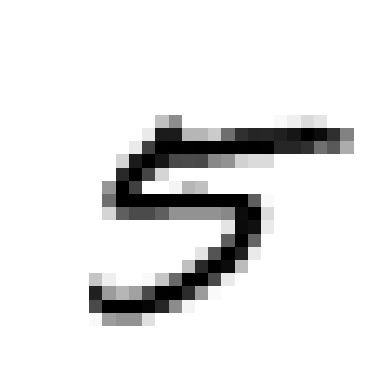

In [16]:
plot_digit(some_digit)

Predict class:

In [17]:
some_digit.shape

sgd_clf.predict([some_digit])


array([ True])

### Test accuracy

In [18]:
y_test = sgd_clf.predict(X_test)

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_test_5)

0.9601

### Cross-validation

#### n-fold cross-validation

<img src="https://raw.githubusercontent.com/astro-informatics/course_mlbd_images/master/Lecture04_Images/5-fold-CV.png" width="700" style="display:block; margin:auto"/>

[Image credit: [VanderPlas](https://github.com/jakevdp/PythonDataScienceHandbook)]

**Exercises:** *You can now complete Exercises 2-3 in the exercises associated with this lecture.*

### Consider naive classifier 

Classify everying as not 5.

In [20]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None): #do nothing
        pass
    def predict(self, X):#predicting 0 or fail
        return np.zeros((len(X), 1), dtype=bool)

What accuracy expect?

In [21]:
from sklearn.model_selection import cross_val_score
# 10 digits, equally same pro
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
# 0.9 is a acceptable accuracy but this is a horrible model

array([0.909  , 0.90745, 0.9125 ])

Need to go beyond classification accuracy, especially for skewed datasets.

## Confusion matrix

Can gain further insight into performance by examining confusion matrix.

### Confusion matrix shows true/false-positive/negative classifications

- True-positive $\text{TP}$: number of true positives (i.e. *correctly classified* as *positive*)
- False-positive $\text{FP}$: number of false positives (i.e. *incorrectly classified* as *positive*)
- True-negative $\text{TN}$: number of true negatives (i.e. *correctly classified* as *negative*)
- False-negative $\text{FN}$: number of false negatives (i.e. *incorrectly classified* as *negative*)


<table>
  <tr>
    <td></td>
    <td></td>
    <td>Predicted</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>Actual</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

### Cross-validation prediction

`cross_val_predict` performs K-fold cross-validation, returing predictions made on each test fold.  Get clean prediction on each test fold, i.e. clean prediction for each instance in the training set.

In [22]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

### Compute confusion matrix

In [23]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_train_5, y_train_pred)
conf_matrix

array([[52953,  1626],
       [  807,  4614]])

Each row represents actual class, while each colum represents predicted class.

### Perfect confusion matrix

In [24]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

**Exercises:** *You can now complete Exercise 4 in the exercises associated with this lecture.*

## Precision and recall

- **Precision**: of **predicted positives**, proportion that are correctly classified (also called *positive predictive value*).

$$\text{precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$


- **Recall**: of **actual positives**, proportion that are correctly classified (also called *true positive rate* or *sensitivity*).

$$\text{recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

Remember:
<table>
  <tr>
    <td></td>
    <td></td>
    <td>Predicted</td>
    <td></td>
  </tr>
  <tr>
    <td></td>
    <td></td>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td>Actual</td>
    <td>Negative</td>
    <td>TN</td>
    <td>FP</td>
  </tr>
  <tr>
    <td></td>
    <td>Positive</td>
    <td>FN</td>
    <td>TP</td>
  </tr>
</table>

**Exercises:** *You can now complete Exercise 5 in the exercises associated with this lecture.*

### $F_1$ score

$F_1$ score is the *harmonic mean* of the precision and recall.

$$F_1 = \frac{2}{1/\text{precision} + 1/\text{recall}} = 2 \frac{\text{precision} \times \text{recall}}{\text{precision} + \text{recall}} = \frac{\text{TP}}{\text{TP} + \frac{\text{FN}+\text{FP}}{2}}$$

$F_1$ favours classifiers that have similar (and high) precision and recall.

Sometimes may wish to favour precision or recall.

**Exercises:** *You can now complete Exercise 6 in the exercises associated with this lecture.*

### Precision-recall tradeoff

Under the hood the classifier computes a *score*.  Binary decision is then made depending on whether score exceeds some *threshold*.

By changing the threshold, one can change the tradeoff between
precision and recall.

Scikit-Learn does not let you set the threshold directly but can access scores (confidence score for a sample is, e.g., the signed distance of that sample to classifying hyperplane).

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([24299.40524152])

Can then make prediction for given threshold of score (depends on the model, and not always has meaning).

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [27]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

#### Compute precision and recall for range of thresholds

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

threshold is kind of used for focusing on the precision or recall.


question: why increasing threshold leads to low recall?

(-700000.0, 700000.0)

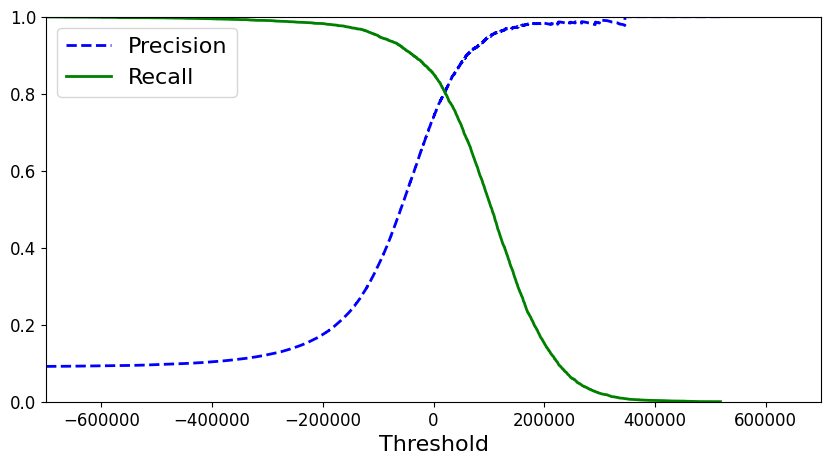

In [30]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(10, 5))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])

*Raising* the threshold *increases precision* and *reduces recall*.

Can select threshold of appropriate trade-off for problem at hand.

Note recall curve smoother than precision since recall related to actual positives and precision related to predicted positives.

## ROC curve

*Receiver operating characteristic* (ROC) curve plots *true positive rate* (i.e. recall) against the *false positive rate* for different *thresholds*.

**Exercises:** *You can now complete Exercise 7 in the exercises associated with this lecture.*

### Plot ROC curve

In [31]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)
# each point on the curve representing a threhold

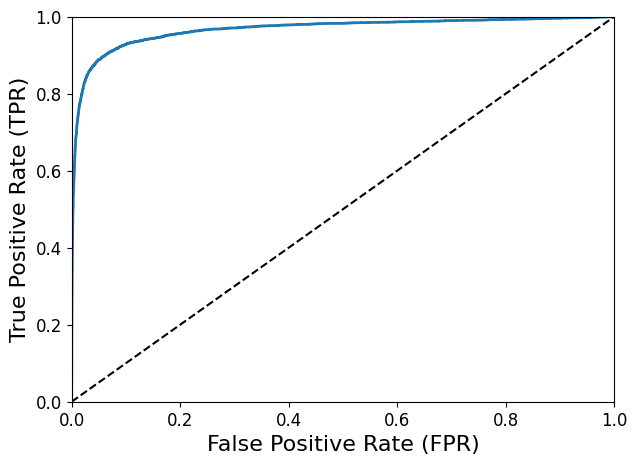

In [32]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(7, 5))
plot_roc_curve(fpr, tpr)
# ideal classifier is the blue line which has area closing to 1
# dash line is the random classifier with area = 1/2

Dashed line corresponds to random classifier.

Again, there is a trade-off.  As the threshold is reduced to increase the true positive rate, we get a larger false positive rate.

**Exercises:** *You can now complete Exercise 8 in the exercises associated with this lecture.*

### Area under the ROC curve

Area under the ROC curve (AUC) is a common performance metric.

In [33]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9668396102663849

**Exercises:** *You can now complete Exercise 9 in the exercises associated with this lecture.*

### Comparing classifier ROC curves

In [34]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [35]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

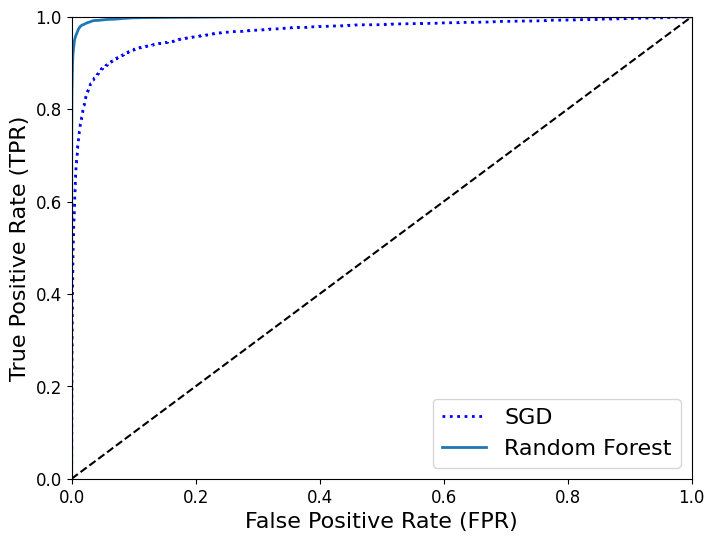

In [36]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)

### Exercise: from the ROC curve, which method appears to work better?

Random Forests since get closer to the ideal point (i.e. top left of plot). 

i.e. closer to the ideal area

### Comparing metrics

In [37]:
# AUC
roc_auc_score(y_train_5, y_scores_forest), roc_auc_score(y_train_5, y_scores)

(0.9983631764491033, 0.9668396102663849)

In [38]:
# Precision
from sklearn.metrics import precision_score, recall_score, f1_score

y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest), precision_score(y_train_5, y_train_pred)

(0.9890893831305078, 0.739423076923077)

In [39]:
# Recall
recall_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred)

(0.8695812580704667, 0.8511344770337577)

In [40]:
# F_1
f1_score(y_train_5, y_train_pred_forest), f1_score(y_train_5, y_train_pred)

(0.9254932757435947, 0.7913558013892462)

### Progress so far

So far we have considered **binary** classification only (e.g. five and not five).

Clearly in many scenarios we want to classify **multiple** classes.

## Multiclass classification

Binary classifiers distinguish between two classes.
Multiclass classifiers can distinguish between more than two classes.

_Some algorithms can handle multiple classes directly (e.g. Random Forests, naive Bayes).
Others are strictly binary classifiers (e.g. Support Vector Machines, Linear classifiers)._

### Multiclass classification strategies


However, there are various strategies that can be used to perform multiclass classification with binary classifiers.

- **One-versus-rest (OvR) / one-versus-all (OvA)**: train a binary classifier for each class, then select classification with greatest score across classifiers 
<br>(e.g. train a binary classifier for each digit).

- **One-versus-one (OvO)**: train a binary classifier for each pair of classes, then select classification that wins most duels 
<br>(e.g. train a binary classifier for each pairs of digits: 0 vs 1, 0 vs 2, ..., 1 vs 2, 1 vs 3, ...).

### Comparison of multiclass classification strategies

**One-versus-rest (OvR)**:
- $N$ classifiers for $N$ classes
- each classifier uses all of the training data

$\Rightarrow$ requires training relatively *few classifiers* but training each classifier can be *slow*.

**One-versus-one (OvO)**:
- $N(N-1)/2$ classifiers  for $N$ classes
- each classifier uses a subset of the training data (typically much smaller than overall training dataset)

$\Rightarrow$ requires training *many* classifiers but training each classifier can be *fast*.

### Preferred approach

**OvR usually preferred**, unless training binary classifier is very slow with large data-sets.

In Scikit-Learn, if try to use binary classifier for a multiclass classification problem, OvR is automatically run.

In [41]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5])

Can see OvR
performed by inspecting scores, where we have a score per classifier.  

The 5th score (starting from 0) is clearly largest.

In [42]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[ -81742.80600673, -226403.87485225, -310042.19433877,
        -173577.43026798,  -82855.74343468,   39922.35938292,
        -183200.20815396,   10437.2327332 , -240036.68142135,
        -160691.66786235]])

In [43]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [44]:
sgd_clf.classes_[np.argmax(some_digit_scores)]

5

### OvO with Scikit-Learn

Can also perform OvO multiclass classification.

In [45]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42, max_iter=10))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit]), len(ovo_clf.estimators_)
# 45 = 10*9/2 where 10 is the 10 digits and 9 is the 9 digits

(array([5]), 45)

### Many classifiers can inherently classify multiple classes

Random Forest can directly classify multiple classes so OvR or OvO classification not required.

In [46]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5])

In [47]:
forest_clf.predict_proba([some_digit])

array([[0.03, 0.01, 0.  , 0.02, 0.02, 0.85, 0.02, 0.03, 0.01, 0.01]])

In [48]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8687 , 0.86975, 0.8449 ])

### Error analysis

Compute confusion matrix for multiclass classification.

In [49]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5765,    2,   16,   16,    7,   21,   33,    9,   48,    6],
       [   1, 6470,   41,   17,    9,   35,   13,   16,  138,    2],
       [  79,   52, 5155,  153,   39,   31,  171,   85,  181,   12],
       [  80,   40,  224, 5087,   19,  286,   62,   78,  217,   38],
       [  37,   30,   46,   15, 5101,   22,   64,   75,  315,  137],
       [ 127,   27,   35,  208,   48, 4451,  175,   35,  259,   56],
       [  45,   10,   57,    3,   19,  112, 5611,   11,   45,    5],
       [  25,   32,   91,   49,   50,   15,    8, 5824,   81,   90],
       [  70,  175,  127,  278,   43,  394,   86,   51, 4571,   56],
       [  48,   33,   54,  117,  326,   99,    5,  801,  834, 3632]])

**Exercises:** *You can now complete Exercise 10 in the exercises associated with this lecture.*

Performance analysis can provide insight into how to make improvements.

For example, for the previous dataset, one might want to consider trying to improve the performane of classifying 9 by collecting more training data for 7s and 9s.